# A Comparative Analysis of Pretrained Models in Enhancing Convulational Neural Network Performance for Binary Image Classification Tasks

Convolutional Neural Networks (CNNs), also known as ConvNets, are a specialized class of deep learning algorithms tailored for visual recognition tasks such as object classification, detection, and segmentation. CNNs have demonstrated remarkable success across a variety of real-world applications, including autonomous vehicles, security systems, and medical imaging.

This project aims to investigate the impact of leveraging pretrained models—such as VGG-16, Inception, ResNet50, and EfficientNet—on improving the performance of CNNs in binary image classification tasks. Specifically, we will focus on classifying images of cats and dogs, drawn from the Cats and Dogs Image Classification dataset on Kaggle.

By fine-tuning these state-of-the-art pretrained models, we will assess their effectiveness in enhancing the accuracy, speed, and generalization of CNNs for the task of distinguishing between images of cats and dogs. The ultimate goal is to evaluate the potential advantages of using these advanced architectures over training a CNN model from scratch, particularly for small-scale datasets.

Dataset Source: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from PIL import Image
from pathlib import Path
import imagesize
import os

### I. Basic CNN Model

Basic CNN models consist of three layers:
- Convulational Layers
    - This layer perform mathematical task called convulation, which is the application of a sliding window function called kerner or filter to a matrix of pixels representing an image. In this layer, serveral filters of equal size are applied, and each filter is used to recognize a specific pattern from the image. After each convulational operation, activation function is applied. One of the most popular activation function is the Rectified Linear Unit (ReLU) Activation Function since it helps learn non-linear relationships between the features in the image, hence making the network more robust for identifying different pattern.
- Pooling Layers
    - This layer perform pulling the most significant features from the convulated matrix from the convulational layers. This can be done through applying some aggregation functions to reduce the dimension of the feature map (convulated matrix). This layer also relevant for mitigating overfitting. One of the most common aggregation function applied is the max pooling, which return the maximum value of the feature map.
- Fully Connected Layers
    - This layers perform flattened the output from the pooling layers into one dimensional matrix. An activation function is also applied. Two of the most popular are sigmoid and softmax. Sigmoid is used for binary classifcation, while softmax is used for multi-class classification. Hence, in this project, sigmoid activation function that is applied.

##### A. Image Preprocessing

When working with image classification using CNN, preprocessing is a crucial step. Preprocessing ensures that the images fed into the model are in a suitable format and are normalized to improve model performance and training speed. ImageDataGenerator are used for preprocessing the images. The preprocessing steps, including:
- Image Normalization
    - Images often have pixel values ranging from 0 to 255. To make model training more efficient, the pixel values can be normalized to a range [0, 1]. Hence, the rescale parameter value in ImageDataGenerator is 1./255. 
- Image Augmentation
    - Image augmentation is a process to artificially expand the size of the dataset by appling random geomatry transformations, such as rotations, flips, zooms, etc, to the training image.
- Image Resizing
    - CNNs typically expect a fixed input size.

1. Finding Optimal Image Size

Unlike pretrained models, which typically require a fixed input size, the basic CNN model doesn't have a predetermined input dimension. As a result, it is essential to determine the optimal image size for the model in order to improve its accuracy. To identify the most effective image dimensions, we will analyze the distribution of the training dataset, considering factors such as image resolution, aspect ratio, and the underlying characteristics of the data. This analysis will guide the selection of an appropriate input size that enhances the model’s performance while maintaining computational efficiency.

In [2]:
train_directory = "../data/train"
image_size_list = []

for root, _, files in os.walk(train_directory):
    for file_name in files:
        file_path = os.path.join(root, file_name)

        image = Image.open(file_path)
        image_size_list.append(image.size)

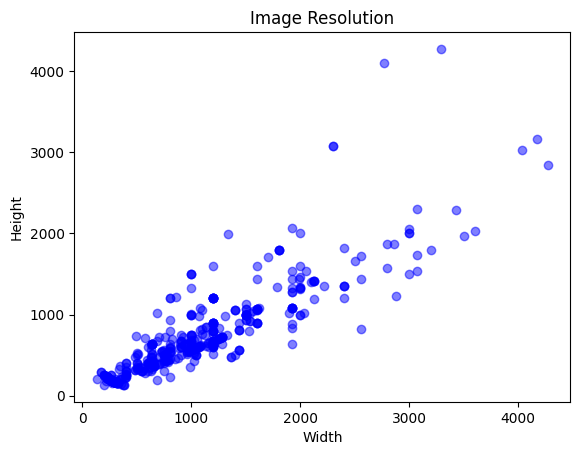

In [3]:
width_list, height_list = zip(*image_size_list)

plt.scatter(width_list, height_list, alpha = 0.5, color = "blue")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution")
plt.show()

Based on the resolution distribution of the images in the training set, the majority of the data clusters within the range of (256, 256) to (1024, 1024) pixels. To strike a balance between model accuracy and computational efficiency, the optimal target input size is set to (512, 512). This value is chosen to represent a middle ground, ensuring that the images are appropriately scaled for the CNN model without unnecessarily increasing processing time or computational load.

2. Train Set Preprocessing

The training set is preprocessed using Keras' ```ImageDataGenerator```, which applies normalization, augmentation, and resizing techniques to enhance model robustness and prevent overfitting.

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.4, 1.5],
    zoom_range = 0.3,
    shear_range = 0.2,
    fill_mode = "nearest"
)

In [5]:
train_set = train_datagen.flow_from_directory(
    directory = "../data/train",
    target_size = (512, 512),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    shuffle = True,
    seed = 42
)

Found 557 images belonging to 2 classes.


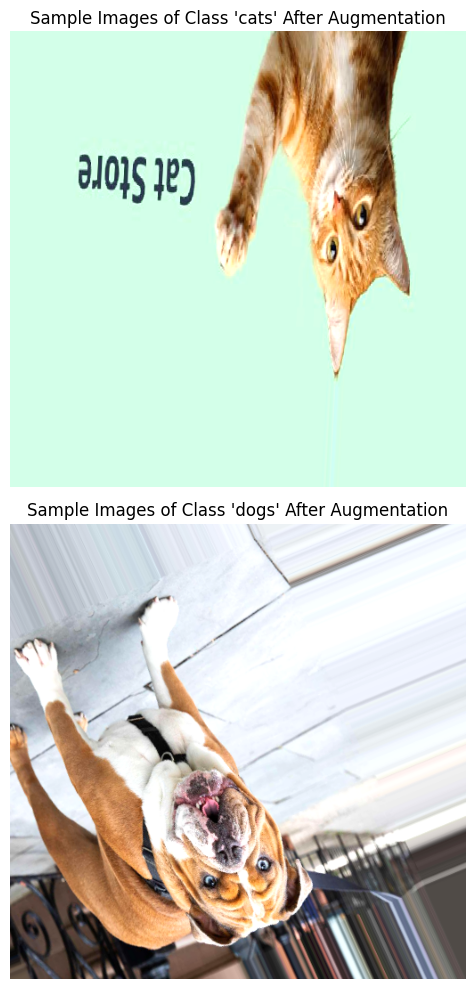

In [8]:
class_labels = list(train_set.class_indices.keys())

plt.figure(figsize = (10, 10))

for i, class_name in enumerate(class_labels):
    images, labels = next(train_set)

    for j in range(len(labels)):
        if labels[j] == i:
            image = images[j]

            plt.subplot(len(class_labels), 1, i + 1)
            plt.imshow(image)
            plt.title(f"Sample Images of Class '{class_name}' After Augmentation")
            plt.axis("off")
            break

plt.tight_layout()
plt.show()

3. Test Set Preprocessing

For the test set, similar preprocessing steps are applied — normalization, resizing — though without the augmentation process to ensure the test data remains consistent with the original distribution.

In [9]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [10]:
test_set = test_datagen.flow_from_directory(
    directory = "../data/test",
    target_size = (512, 512),
    batch_size = 32,
    class_mode = "binary"
)

Found 140 images belonging to 2 classes.


4. Class Distribution

In [11]:
class_counts = [len(os.listdir(os.path.join(train_directory, class_name))) for class_name in class_labels]

class_distribution = pd.DataFrame({
    "Class": class_labels,
    "Count": class_counts
}).sort_values(by = "Count", ascending = False)

C:\Users\PC\AppData\Local\Temp\ipykernel_5780\2152842193.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


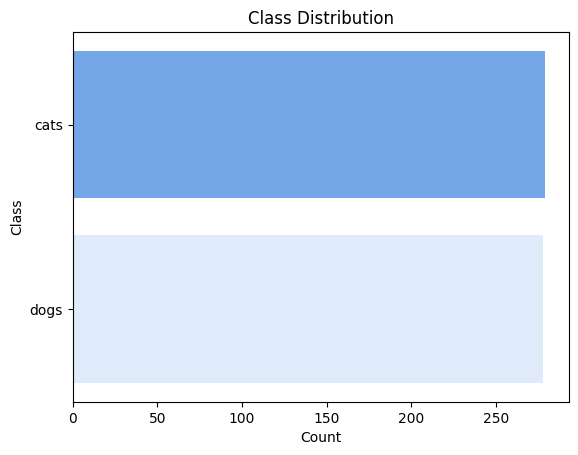

In [12]:
sns.barplot(
    data = class_distribution,
    x = "Count",
    y = "Class",
    orient = "h",
    palette = ["#60a5fa" if i == 0 else "#dbeafe" for i in range(len(class_distribution))],
    order = class_distribution["Class"]
)

plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Class Distribution")

plt.show()

The distribution of the 'cats' and 'dogs' classes is nearly balanced, with only a small difference in sample size between the two categories. This minor discrepancy ensures that the dataset remains largely balanced, making it suitable for training with minimal risk of bias towards either class.

##### B. Modeling

The architecture that is used on the basic CNN model is:
- Convulational Layer 1
    - Filters: 32
    - Kernel Size: 3 x 3
    - Regularizer: L2 (0.00005)
    - Padding: Same
    - Batch Normalization
    - ReLU Activation Function
- Pooling Layer 1
    - Pool Size: 2 x 2
    - Strides: 2
- Convulational Layer 2
    - Filters: 32
    - Kernel Size: 3 x 3
    - Regularizer: L2 (0.00005)
    - Padding: Same
    - Batch Normalization
    - ReLU Activation Function
- Pooling Layer 2
    - Pool Size: 2 x 2
    - Strides: 2
- Flatten Layer
- Fully Connected Layer
    - Units: 128,
    - Regularizer: L2 (0.00005)
    - Batch Normalization
    - ReLU Activation Function
- Dropout Layer
    - Rate: 0.4
- Output Layer
    - Units: 1
    - Sigmoid Activation Function

The model will be compiled using the Adam optimizer with a learning rate of 0.0001. Additionally, early stopping will be applied, monitoring the validation loss to prevent overfitting.

In [78]:
cnn = tf.keras.models.Sequential()

In [79]:
# Convulational Layer 1
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size = 3, 
    input_shape = [512, 512, 3], 
    kernel_regularizer = tf.keras.regularizers.l2(0.00005),
    padding = "same"
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())

# Pooling Layer 1
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size = 2, 
    strides = 2
))

# Convulational Layer 2
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size = 3, 
    kernel_regularizer = tf.keras.regularizers.l2(0.00005),
    padding = "same"
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())

# Pooling Layer 2
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size = 2, 
    strides = 2
))

# Flatten Layer 
cnn.add(tf.keras.layers.Flatten())

# Fully Connected Layer 1
cnn.add(tf.keras.layers.Dense(
    units = 128,
    kernel_regularizer = tf.keras.regularizers.l2(0.00005)
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())


# Droput Layer
cnn.add(tf.keras.layers.Dropout(0.4))

# Output Layer
cnn.add(tf.keras.layers.Dense(
    units = 1, 
    activation = "sigmoid"
))

In [80]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 5, 
    restore_best_weights = True
)

In [81]:
cnn.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "binary_crossentropy", 
    metrics = ["accuracy"]
)

In [82]:
history = cnn.fit(
    train_set, 
    validation_data = test_set, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.4766 - loss: 1.0561 - val_accuracy: 0.4929 - val_loss: 0.7576
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5547 - loss: 0.7777 - val_accuracy: 0.5000 - val_loss: 0.7275
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5913 - loss: 0.7326 - val_accuracy: 0.6000 - val_loss: 0.7073
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6155 - loss: 0.7210 - val_accuracy: 0.5857 - val_loss: 0.7091
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5664 - loss: 0.7312 - val_accuracy: 0.5286 - val_loss: 0.7055
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5475 - loss: 0.7617 - val_accuracy: 0.5714 - val_loss: 0.7020
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6005 - loss: 0.7180 - val_accuracy: 0.5500 - val_loss: 0.7017
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5802 - loss: 0.7653 - val_accuracy: 0.5571 - v

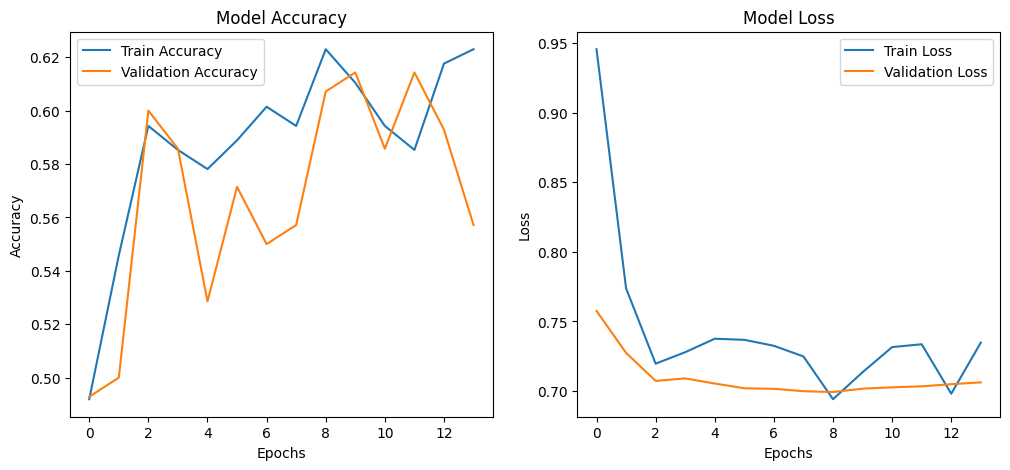

In [83]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(history.history["accuracy"], label = "Train Accuracy")
axes[0].plot(history.history["val_accuracy"], label = "Validation Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].plot(history.history["loss"], label = "Train Loss")
axes[1].plot(history.history["val_loss"], label = "Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

In [86]:
cnn.save("../models/basic_cnn.h5")
cnn.save("../models/basic_cnn.keras")

The basic model achieved 65.03% training accuracy and 60.71% validation accuracy.

### II. VGG-16

VGG-16 is a CNN architecture developed by the Visual Geometry Group (VGG) at the University of Oxford. It consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. Known for its simplicity and uniform structure, VGG-16 utilizes small 3x3 convolutional kernels and deep stacking of layers to capture hierarchical image features effectively. This architecture has been widely used for image classification and feature extraction in various deep learning applications.

![VGG_16 Arhictecture](https://cdn.analyticsvidhya.com/wp-content/uploads/2024/09/vgg16-neural-network.webp)

##### A. Image Preprocessing

##### B. Modeling

### III. Inception V3

Inception V3 is a CNN Architecture from the Inception family. It consist of 48 layers deep. The architecture was designed to facilitate the construction of deeper neural networks while preventing an excessive increase in the number of parameters.

![Inception Architecture](https://miro.medium.com/v2/resize:fit:720/format:webp/1*KCN-kGnobrtSUdvKsTZMOg.png)

### IV. ResNet50

### V. EfficientNet

### VI. Conclusion

<table>
    <thead>
        <tr>
            <td rowspan = "2"> Model </td>
            <td colspan = "2"> Train </td>
            <td colspan = "2"> Test </td>
            <td rowspan = "2"> Train Time </td>
        </tr>
        <tr>
            <td> Accuracy </td>
            <td> Loss </td>
            <td> Accuracy </td>
            <td> Loss </td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td> Basic CNN </td>
            <td> 65.03% </td>
            <td> 0.6554 </td>
            <td> 60.71% </td>
            <td> 0.6993 </td>
            <td> 10m 26.6s</td>
        </tr>
    </tbody>
</table>

### VII. References

- Bhandari, A. (2024). Image augmentation on the fly using Keras ImageDataGenerator!. https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
- Chollet, F. (2016). Building powerful image classification models using very little data. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- Ghantiwala, A. (2022). Understanding architecture of inception network & applying it to a real world dataset. https://gghantiwala.medium.com/understanding-the-architecture-of-the-inception-network-and-applying-it-to-a-real-world-dataset-169874795540
- Gupta, S. (2020). Inception v3 model. https://www.kaggle.com/datasets/imsparsh/inception-v3-model
- hima_maddala. (2024). Building an image classifier model using pretrained inception v3. https://medium.com/@maddalahima/building-an-image-classifier-model-using-pretrained-inceptionv3-566bee431352
- Huilgol, P. (2024). Top 4 pre-trained models for image classification with Python code. https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
- J, Vijayabhaskar. (2018). Tutorial on using Keras flow_from_directory and generators. https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
- Keita, Z. (2023). An introduction to convulational neural networks (CNNs). https://www.datacamp.com/tutorial/introduction-to-convolutional-neural-networks-cnns
- Patel, M. (2023). The complete guide to image preprocessing techniques in Python. https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c
- Ramalingam, A. (2021). How to pick the optimal size for training convulational neural network?. https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05
- (2024). VGG-16 | CNN model. https://www.geeksforgeeks.org/vgg-16-cnn-model/